# Topic Modeling
https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/11-Topic-Modeling-Time-Series.html

In [1]:
# !pip install little_mallet_wrapper
# !pip install seaborn
# !pip install --upgrade pip
# !pip install wordcloud
# !pip install spacy
# !pip install pyLDAvis
# !pip install gensim==3.8.3
# !pip install bertopic
# !pip install bertopic[visualization]

# Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path
import sys
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk


import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import gensim.models.wrappers.ldamallet
from pprint import pprint

import spacy

import pickle
import re 
import pyLDAvis
import pyLDAvis.gensim_models

import matplotlib.pyplot as plt 
import pandas as pd

from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS
from nltk.tokenize import word_tokenize

/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [3]:
path_to_mallet = 'mallet/bin/mallet'

# Declare Stop Words

In [4]:
# remove specified stopwords 
all_stopwords_gensim = STOPWORDS.union(set(['a', 'about', 'above', 'above', 'across', 'after', 'cpt',
    'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along',
    'already', 'also','although','always','am','among', 'amongst', 'amoungst',
    'amount',  'an', 'and', 'another', 'any','anyhow','anyone','anything','anyway',
    'anywhere', 'are', 'around', 'as',  'at', 'back','be','became', 'because','become',
    'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below',
    'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom','but', 'by',
    'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 'cry', 'de',
    'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight',
    'either', 'eleven','else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever',
    'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fify',
    'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found',
    'four', 'from', 'front', 'full', 'further', 'get', 'give', 'go', 'had', 'has', 'hasnt',
    'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon',
    'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'ie', 'if',
    'in', 'inc', 'indeed', 'interest', 'into', 'is', 'it', 'its', 'itself', 'keep', 'last',
    'latter', 'latterly', 'least', 'less', 'like', 'ltd', 'make', 'making', 'made', 'many', 'may', 'me', 'meanwhile',
    'might', 'mill', 'mine', 'more', 'moreover', 'most', 'mostly', 'move', 'much', 'must',
    'my', 'myself', 'name', 'namely', 'neither', 'never', 'nevertheless', 'next', 'nine',
    'no', 'nobody', 'none', 'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of', 'off',
    'often', 'on', 'once', 'one', 'only', 'onto', 'or', 'other', 'others', 'otherwise',
    'our', 'ours', 'ourselves', 'out', 'over', 'own','part', 'per', 'perhaps', 'please',
    'put', 'rather', 're', 'same', 'see', 'seem', 'seemed', 'seeming', 'seems', 'serious',
    'several', 'she', 'should', 'show', 'side', 'since', 'sincere', 'six', 'sixty', 'so',
    'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere',
    'still', 'such', 'system', 'take', 'ten', 'than', 'that', 'the', 'their', 'them',
    'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore',
    'therein', 'thereupon', 'these', 'they', 'thickv', 'thin', 'third', 'this', 'those',
    'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too',
    'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'un', 'under', 'until', 'up',
    'upon', 'us', 'very', 'via', 'was', 'we', 'well', 'were', 'what', 'whatever', 'when',
    'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein',
    'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever',
    'whole', 'whom', 'whose', 'why', 'will', 'with', 'within', 'without', 'would', 'yet',
    'you', 'your', 'yours', 'yourself', 'yourselves', 'the']));

# Reading text files data

In [5]:
files = glob.glob(f"Files/*.txt")

# print(len(files))
# files

In [6]:
training_data = []
for file in files:
    text = open(file, encoding='utf-8').read()
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove')
    training_data.append(processed_text)

In [7]:
original_texts = []
for file in files:
    text = open(file, encoding='utf-8').read()
    original_texts.append(text)

In [8]:
obit_titles = [Path(file).stem for file in files]
obit_titles

['Kim2018-Enhancing_employee_communication',
 'Harviainen2022-Inf-Creation-Game-Sensemaking',
 'Holman2019-Health-Miscarriage-Communicated-Narrative-Sensemaking',
 'Vignoli2022-Machine-Learning-Sensemaking',
 'Sahay2021-Nurses-Sensemaking-US',
 'Zhou2021-The Values of Print Affordances and Sensemaking for Newspaper Consumers',
 'Horstman2021-Health-Memorable Messages Embedded in Men s Stories of Miscarriage Extending Communicated Narrative Sense Making and Memorable Message Theorizing',
 'Williams2018-Discourses of an Organizational Tragedy Emotion Sensemaking and Learning After the Yarnell Hill Fire',
 'Biss2022-Sensemaking-Survivors-Assault',
 'Barney2021-Communicative-Narrative-Sensemaking',
 'Horstman2019-Communicated-Narrative-Sensemaking',
 'Jones2020-Retrospective-Sensemaking-Global-Financial-Crisis',
 'Wyant2022-Employees-Sensemaking-Expatriates',
 'Shaw2020-Sensemaking-Scholarly-Communications-Global-Pandemic',
 'Cooper2021-Family-Communicated-Narrative-Sensemaking-Theory',
 '

In [9]:
little_mallet_wrapper.print_dataset_stats(training_data)

Number of Documents: 37
Mean Number of Words per Document: 3860.8
Vocabulary Size: 12041


# Text cleaning

In [10]:
#Tokenizing
from nltk.tokenize import RegexpTokenizer
nltk_tokenizer=RegexpTokenizer(r'\w+')

# documents = original_texts
documents = training_data
# print(type(original_texts))
for index,document in enumerate(documents):
    documents[index]= nltk_tokenizer.tokenize(document)

In [11]:
# Removing stop words 

stop_words=set(stopwords.words("english"))
stop_words = stop_words.union(all_stopwords_gensim)
# print(stopwords.words('english'))

for index,document in enumerate(documents):
    documents[index]=[w for w in document if w not in stop_words ]
    

# text_tokens = word_tokenize(text)
# tokens_without_sw = [word for word in text_tokens if not word in all_stopwords_gensim]
# print(tokens_without_sw)

data = []
for i in documents:
    data += i

training_data = data
# print(type(data))
# data

text_tokens = word_tokenize(' '.join(data))

tokens_without_sw = [word for word in text_tokens if not word in stop_words]

# print(tokens_without_sw)

In [12]:
training_data = tokens_without_sw
filtered_sentence = ' '.join(training_data)
# print(type(training_data))


In [13]:
num_topics = 15
# training_data = training_data
# training_data = documents

output_directory_path = 'Test'

#No need to change anything below here
Path(f"{output_directory_path}").mkdir(parents=True, exist_ok=True)

path_to_training_data           = f"{output_directory_path}/training.txt"
path_to_formatted_training_data = f"{output_directory_path}/mallet.training"
path_to_model                   = f"{output_directory_path}/mallet.model.{str(num_topics)}"
path_to_topic_keys              = f"{output_directory_path}/mallet.topic_keys.{str(num_topics)}"
path_to_topic_distributions     = f"{output_directory_path}/mallet.topic_distributions.{str(num_topics)}"

In [14]:
little_mallet_wrapper.quick_train_topic_model(path_to_mallet,
                                             output_directory_path,
                                             num_topics,
                                             training_data)

Importing data...
Complete
Training topic model...


Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 1
total tokens: 129487
<10> LL/token: -12.31275
<20> LL/token: -12.0263
<30> LL/token: -11.88498
<40> LL/token: -11.80218

0	0.33333	story analysis community future communication members told provide taking play effects world change decisions research felt information newspaper dominant aspects 
1	0.33333	research members family digital important relationship view performance interaction key flint users mother said confidants couples media implications survivors noted 
2	0.33333	sense information example experience questions understand cnsm public csr managers research help identities people created providing importance african affect features 
3	0.33333	support data experiences family way employees focus group tongqi learning participants strategies number associated memorable including thinking evidence sensegiving gender 
4	0.33333	understanding information participants cognitive potential systems ordances

<160> LL/token: -11.61174
<170> LL/token: -11.61456
<180> LL/token: -11.60755
<190> LL/token: -11.59942

0	0.33333	communication analysis future information expatriates understand told including managers world needed self felt type given develop going newspaper aspects decisions 
1	0.33333	members research digital family know users change confidants practices relationship decision performance things mother researchers loss flint noted lack implications 
2	0.33333	research experience sense information example sexual questions issues order described affect csr providing importance provided african graphs features algorithmic idea 
3	0.33333	support experiences way family learning group data tongqi focus pregnancy actions strategies material wife associated discussed evidence practice conducted gender 
4	0.33333	understanding meaning results cognitive systems behaviors events years discussion ordances interviews identities potential job play difficult present working print experienced 
5	

[beta: 0.03519] 
<310> LL/token: -11.94688
[beta: 0.03491] 
<320> LL/token: -11.94494
[beta: 0.03467] 
<330> LL/token: -11.92861
[beta: 0.03484] 
<340> LL/token: -11.94174

0	0.34346	communication information members analysis women future understand design told expatriates sense participant mother community place level assault different csr seeking 
1	0.33746	research family know positive sensemaking perspective relationship potential trust practices confidants narrative described groups identities change individual organization lack meaning 
2	0.32877	sense example research sexual experience processes questions response perceived included loss context influence involved algorithmic certain information world affordances identifying 
3	0.34813	data learning way support approach tongqi family experiences noted managers caregiving individuals perceptions management contexts case marketing existing cials past 
4	0.32595	understanding results organizational cognitive self systems meaning pl

[beta: 0.03525] 
<460> LL/token: -11.95534
[beta: 0.03493] 
<470> LL/token: -11.94807
[beta: 0.03496] 
<480> LL/token: -11.95098
[beta: 0.03501] 
<490> LL/token: -11.95347

0	0.35639	communication women new members expatriates community analysis information identity mental needs told caregiving employees created environment particular specific view themes 
1	0.34064	research individual systems media know practices trust level interaction confidants lack role understanding tongqi graphs disclosure given reports assault shared 
2	0.32431	sense experience example cultural public discourses material taking context want technology husband conducted stress students relationship deceased non power young 
3	0.34947	data family individuals sense learning search effects memorable type csr relevant negative explore shared noted global seeking tools agencies decision 
4	0.33789	sensemaking crisis findings organization nurses results caregivers think play cognitive current brand world self place tu

[beta: 0.03512] 
<610> LL/token: -11.95889
[beta: 0.03548] 
<620> LL/token: -11.95485
[beta: 0.03544] 
<630> LL/token: -11.94728
[beta: 0.03504] 
<640> LL/token: -11.94724

0	0.38044	communication news future expatriates analysis researchers issues potential new mental relevant flint women leadership number managers discussion particular problem provided 
1	0.34921	research family individual provide tongqi sense role systems questions women water focus level effects survivors specific narrative death advertising action 
2	0.31562	example sense context cultural studies task csr identities students identified complex lack material public importance husband gender foresight articles case 
3	0.38784	data sense process individuals experience learning families time shared including view visual family job memorable working experiences interaction agencies similar 
4	0.33155	sensemaking findings narratives know messages caregivers development cnsm personal assault response perceptions model cu

[beta: 0.03532] 
<760> LL/token: -11.96498
[beta: 0.03527] 
<770> LL/token: -11.95695
[beta: 0.03563] 
<780> LL/token: -11.96697
[beta: 0.03575] 
<790> LL/token: -11.97088

0	0.40463	communication stories news women analysis expatriates new results provide potential role lead narratives leadership changes significant pregnancy providing problem flint 
1	0.33209	research role related questions local family systems mother user effects researchers tongqi death create dominant individual sandbox impact lgbtq approach 
2	0.29465	different process critical example identified lack think cultural multiple people context caregiving disclosure attention community particular print reported csr future 
3	0.44819	data sense experience individuals family narrative men learning themes story organizational need individual water perspective including visual change life similar 
4	0.31118	sense findings users sensemaking messages focus caregivers key discourses cnsm self relationships place development 

[beta: 0.03569] 
<910> LL/token: -11.97475
[beta: 0.03603] 
<920> LL/token: -11.97445
[beta: 0.03585] 
<930> LL/token: -11.98806
[beta: 0.03574] 
<940> LL/token: -11.98806

0	0.43822	stories communication analysis women news organization narratives support local community survivors performance second expatriates use interaction set advertising seeking noted 
1	0.33259	research family role related approach self studies questions pregnancy based relevant outcomes satisfaction needs certain messages care algorithms focus sandbox 
2	0.28509	process example different future shared critical story individual given water research included relational business talk despite phase affordances intercultural step 
3	0.48475	sense data experience individuals narrative social need men public themes cultural visual families including literature following strategies life affect csr 
4	0.32591	new findings help change focus marketing place key likely engage expatriates changes development member search d

Complete


([['communication',
   'stories',
   'support',
   'news',
   'analysis',
   'women',
   'digital',
   'organization',
   'local',
   'groups',
   'performance',
   'survivors',
   'closet',
   'interaction',
   'identified',
   'set',
   'tongqi',
   'expatriates',
   'instance',
   'caregiving'],
  ['family',
   'role',
   'based',
   'studies',
   'self',
   'pregnancy',
   'relevant',
   'questions',
   'outcomes',
   'needs',
   'decisions',
   'research',
   'thinking',
   'share',
   'communicated',
   'material',
   'present',
   'life',
   'result',
   'struggle'],
  ['process',
   'future',
   'mental',
   'critical',
   'different',
   'significant',
   'individual',
   'lead',
   'event',
   'included',
   'help',
   'example',
   'people',
   'stress',
   'given',
   'shared',
   'team',
   'despite',
   'review',
   'phase'],
  ['sense',
   'data',
   'experience',
   'individuals',
   'narrative',
   'men',
   'social',
   'need',
   'themes',
   'families',
   'second',

# Determine most common words

In [15]:
# Term Count/Freq.
wordlist = ' '.join(training_data).split()
wordfreq = [wordlist.count(w) for w in wordlist] # a list comprehension

# print("String\n" + wordstring +"\n")
# print("List\n" + str(wordlist) + "\n")
# print("Frequencies\n" + str(wordfreq) + "\n")
# print("Pairs\n" + str(list(zip(wordlist, wordfreq))))
# type(wordlist)
# print(wordlist)


In [16]:
# Top 100 words are more freq.
from tabulate import tabulate
from collections import Counter
# Counter(wordlist).most_common(100)
print (tabulate(Counter(wordlist).most_common(100), headers=["Word", "Count"]))

Word              Count
--------------  -------
sensemaking         941
sense               857
information         742
research            682
data                665
communication       654
participants        642
study               621
process             569
miscarriage         539
stories             455
family              433
health              421
crisis              415
members             371
experience          365
people              361
social              358
news                352
individuals         340
identity            321
employees           318
based               318
role                310
media               308
support             307
understanding       304
narrative           303
new                 302
work                301
experiences         299
use                 290
analysis            280
different           278
example             275
knowledge           271
important           268
men                 268
time                263
way             

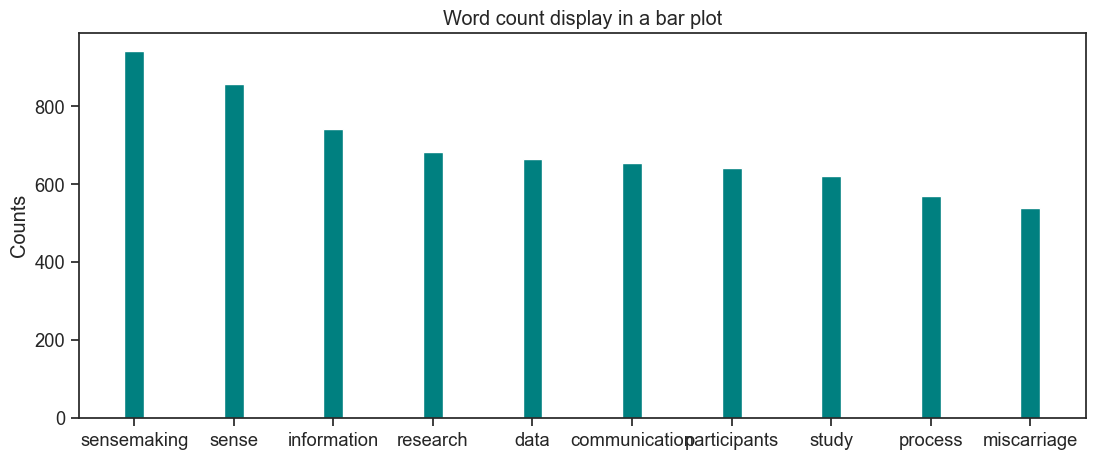

In [17]:
# Represent words count in bar plot

t = Counter(wordlist).most_common(10)
x = []
for a in t:
    x+=list(a) 
#     print(x)

def Convert(lst):
    res_dct = {lst[i]: lst[i + 1] for i in range(0, len(lst), 2)}
    return res_dct
         
# Driver code
lst = x
# print(Convert(lst))

import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = Convert(lst)
courses = list(data.keys())
values = list(data.values())
# print(courses)
fig = plt.figure(figsize = (13, 5))

# creating the bar plot
plt.bar(courses, values, color = 'teal', width = 0.2)

# plt.xlabel("Words")
plt.ylabel("Counts")
plt.title("Word count display in a bar plot")
plt.show()


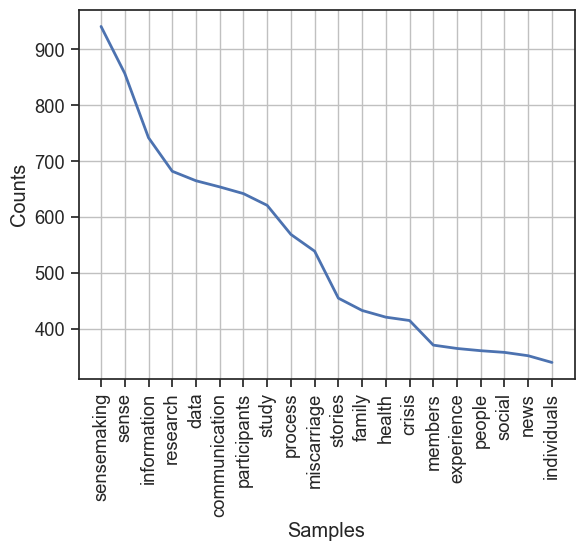

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [18]:
all_words=nltk.FreqDist(wordlist)
# print(all_words.most_common(100))
# print(type(all_words.most_common(100)))
all_words.plot(20)

# Creating Word Cloud

In [19]:
text = ' '.join(training_data)
# wordcloud = WordCloud(max_words=100).generate(text)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(text)
 

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/li

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/li

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/li

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

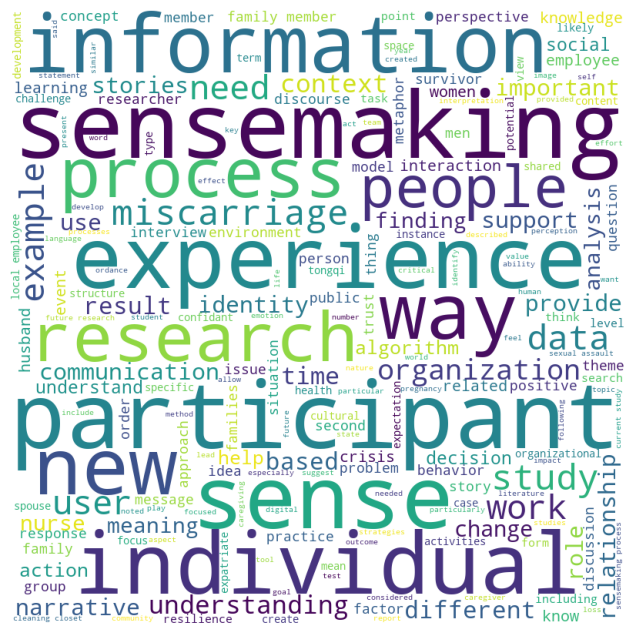

In [20]:
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# WordCloud in Topic level

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/li

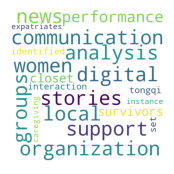

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation i

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

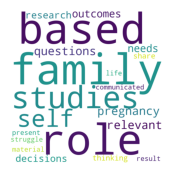

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation i

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

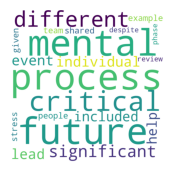

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wo

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

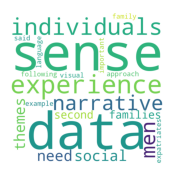

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

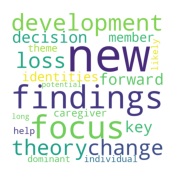

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wo

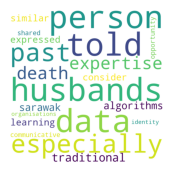

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

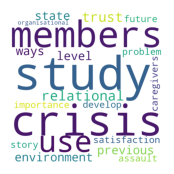

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wo

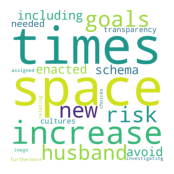

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

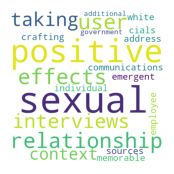

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

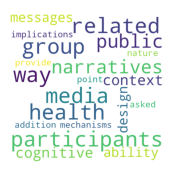

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

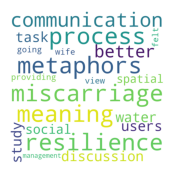

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wo

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

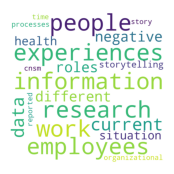

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

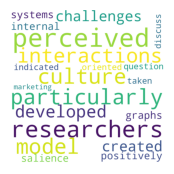

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

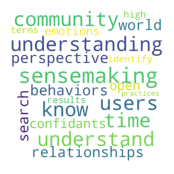

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wo

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/anaconda3/li

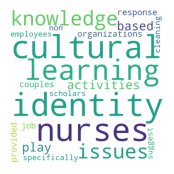

In [21]:
topics = little_mallet_wrapper.load_topic_keys(path_to_topic_keys)
# t = pd.DataFrame(topics)
# t.head()
wc = []
for topic_number, topic in enumerate(topics):
#     print(f"✨Topic {topic_number}✨\n\n{topic}\n")
    text = ' '.join(topic)
# wordcloud = WordCloud(max_words=100).generate(text)
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(text)
    wc.append(wordcloud)
# plot the WordCloud image                      
    plt.figure(figsize = (2, 2), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [22]:
topics = little_mallet_wrapper.load_topic_keys(path_to_topic_keys)
# t = pd.DataFrame(topics)
# t.head()
for topic_number, topic in enumerate(topics):
    print(f"✨Topic {topic_number}✨\n\n{topic}\n")
     

✨Topic 0✨

['communication', 'stories', 'support', 'news', 'analysis', 'women', 'digital', 'organization', 'local', 'groups', 'performance', 'survivors', 'closet', 'interaction', 'identified', 'set', 'tongqi', 'expatriates', 'instance', 'caregiving']

✨Topic 1✨

['family', 'role', 'based', 'studies', 'self', 'pregnancy', 'relevant', 'questions', 'outcomes', 'needs', 'decisions', 'research', 'thinking', 'share', 'communicated', 'material', 'present', 'life', 'result', 'struggle']

✨Topic 2✨

['process', 'future', 'mental', 'critical', 'different', 'significant', 'individual', 'lead', 'event', 'included', 'help', 'example', 'people', 'stress', 'given', 'shared', 'team', 'despite', 'review', 'phase']

✨Topic 3✨

['sense', 'data', 'experience', 'individuals', 'narrative', 'men', 'social', 'need', 'themes', 'families', 'second', 'following', 'approach', 'visual', 'family', 'expatriates', 'important', 'language', 'example', 'said']

✨Topic 4✨

['new', 'findings', 'focus', 'development', 'cha

In [23]:
from tabulate import tabulate

df = pd.DataFrame(topics, columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic'+str(i) for i in range(1, 16)])
df.head()


Term1     Term2       Term3        Term4      Term5  \
Topic1  communication   stories     support         news   analysis   
Topic2         family      role       based      studies       self   
Topic3        process    future      mental     critical  different   
Topic4          sense      data  experience  individuals  narrative   
Topic5            new  findings       focus  development     change   

              Term6       Term7         Term8     Term9    Term10  \
Topic1        women     digital  organization     local    groups   
Topic2    pregnancy    relevant     questions  outcomes     needs   
Topic3  significant  individual          lead     event  included   
Topic4          men      social          need    themes  families   
Topic5         loss      theory      decision   forward       key   

             Term11     Term12     Term13       Term14        Term15  \
Topic1  performance  survivors     closet  interaction    identified   
Topic2    decisions   research   thinking        share  communicated   
Topic3         help    example     people       stress         given   
Topic4       second  following   approach       visual        family   
Topic5   identities     member  caregiver        theme      dominant   

             Term16      Term17       Term18     Term19      Term20  
Topic1          set      tongqi  expatriates   instance  caregiving  
Topic2     material     present         life     result    struggle  
Topic3       shared        team      despite     review       phase  
Topic4  expatriates   important     language    example        said  
Topic5       likely  individual         help  potential        long

In [24]:
topic_distributions = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions)
topic_distributions

[[0.06396384900700566,
  0.047557002835401124,
  0.03874300310500437,
  0.07172241131392985,
  0.1875332494990997,
  0.03049267224222833,
  0.1978558443244128,
  0.017368341041738938,
  0.03320594933383276,
  0.05279016628640215,
  0.051502601753677504,
  0.07108134811692272,
  0.03106185811811656,
  0.0598690493559005,
  0.04525265366632692],
 [0.06396384900700566,
  0.047557002835401124,
  0.03874300310500437,
  0.07172241131392985,
  0.045307944507085016,
  0.03049267224222833,
  0.05563053933239809,
  0.017368341041738938,
  0.17543125432584744,
  0.05279016628640215,
  0.051502601753677504,
  0.2133066531089374,
  0.03106185811811656,
  0.0598690493559005,
  0.04525265366632692],
 [0.20618915399902035,
  0.047557002835401124,
  0.03874300310500437,
  0.07172241131392985,
  0.045307944507085016,
  0.03049267224222833,
  0.05563053933239809,
  0.017368341041738938,
  0.03320594933383276,
  0.05279016628640215,
  0.051502601753677504,
  0.07108134811692272,
  0.03106185811811656,
  0

In [25]:
# target_labels = ['Ahmad2020-SDE-Org-Sensemaking', 'Asso for Info Science   Tech - 2019 - Zhang - Cognitive mechanisms in sensemaking  A qualitative user study']
target_labels = files


In [26]:
import random
target_labels = random.sample(obit_titles, len(files))

# Heatmap Representation

/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.9/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


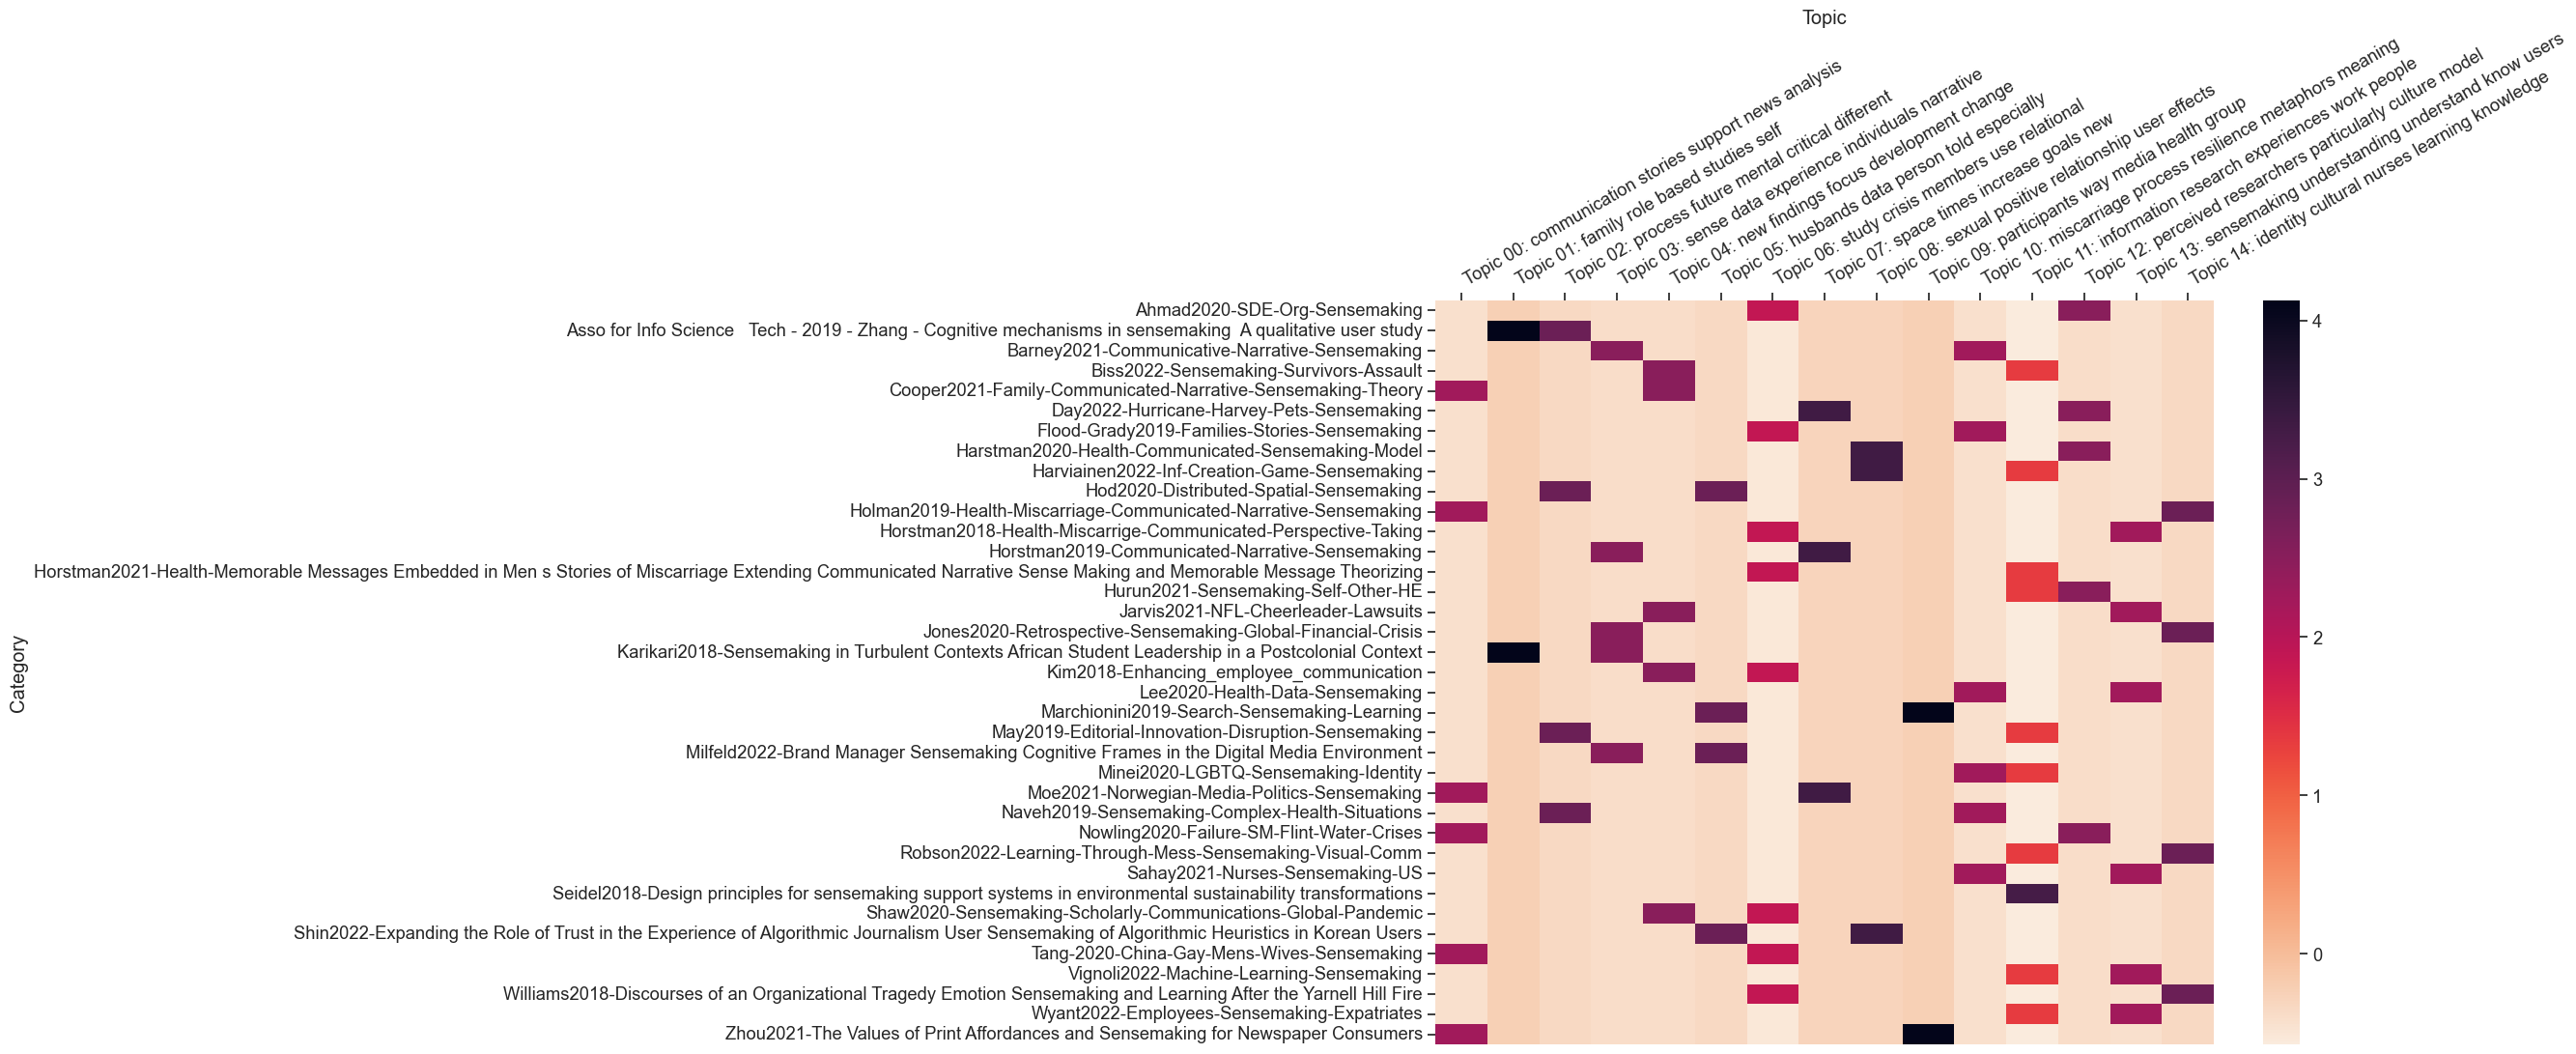

In [27]:
little_mallet_wrapper.plot_categories_by_topics_heatmap(obit_titles,
                                      topic_distributions,
                                      topics, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim= (13, 10)
                                     )

In [28]:
training_data_obit_titles = dict(zip(training_data, obit_titles))
training_data_original_text = dict(zip(training_data, original_texts))

In [29]:
# def display_top_titles_per_topic(topic_number=0, number_of_documents=5):
    
#     print(f"✨Topic {topic_number}✨\n\n{topics[topic_number]}\n")

#     for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
# #         print(document)
# #         print( training_data_obit_titles)
        
#         print(round(probability, 4), training_data_obit_titles[document] + "\n")
#     return

In [30]:
# display_top_titles_per_topic(topic_number=0, number_of_documents=5)

In [31]:
# display_top_titles_per_topic(topic_number=9, number_of_documents=5)

In [32]:
# display_top_titles_per_topic(topic_number=8, number_of_documents=7)

In [33]:
# from IPython.display import Markdown, display
# import re

# def display_bolded_topic_words_in_context(topic_number=3, number_of_documents=3, custom_words=None):

#     for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
        
#         print(f"✨Topic {topic_number}✨\n\n{topics[topic_number]}\n")
        
#         probability = f"✨✨✨\n\n**{probability}**"
#         obit_title = f"**{training_data_obit_titles[document]}**"
#         original_text = training_data_original_text[document]
#         topic_words = topics[topic_number]
#         topic_words = custom_words if custom_words != None else topic_words

#         for word in topic_words:
#             if word in original_text:
#                 original_text = re.sub(f"\\b{word}\\b", f"**{word}**", original_text)

#         display(Markdown(probability)), display(Markdown(obit_title)), display(Markdown(original_text))
#     return

In [34]:
# display_bolded_topic_words_in_context(topic_number=3, number_of_documents=3)

In [35]:
# display_bolded_topic_words_in_context(topic_number=8, number_of_documents=3)

# LSA Model

In [36]:
dt = ' '.join(training_data).split()
dt = [t.split(',') for t in dt]
id2word = Dictionary(dt)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in dt]
# print(corpus[:1])
# print(type(wordlist))
# print(len(wordlist))

In [37]:
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

# find the coherence score with a different number of topics
for i in range(2,11):
    lsi = LsiModel(corpus, num_topics=i, id2word=id2word)    
    coherence_model = CoherenceModel(model=lsi, texts=dt, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, 

Coherence score with 2 clusters: 0.8576868094997991


/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, 

Coherence score with 3 clusters: 0.8546956414266967


/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, 

Coherence score with 4 clusters: 0.8493981309727047


/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, 

Coherence score with 5 clusters: 0.8485700687632305


/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, 

Coherence score with 6 clusters: 0.8454766664169228


/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, 

Coherence score with 7 clusters: 0.8454095043863433


/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, 

Coherence score with 8 clusters: 0.8399360246186344


/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, 

Coherence score with 9 clusters: 0.8421372512873982


/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, 

Coherence score with 10 clusters: 0.839482250558583


In [38]:
from gensim.models import LsiModel

lsamodel = LsiModel(corpus=corpus, num_topics=250, id2word=id2word)
# print(lsamodel.num_topics)
print(lsamodel.print_topics(num_topics=250))

/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(m, n, samples, corpus.indptr, corpus.indices,
/opt/anaconda3/lib/python3.9/site-packages/gensim/models/lsimodel.py:926: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, 

[(0, '-1.000*"sensemaking" + -0.000*"crisis" + 0.000*"nature" + -0.000*"expressed" + 0.000*"factors" + -0.000*"involved" + -0.000*"perspectives" + -0.000*"community" + 0.000*"especially" + 0.000*"created"'), (1, '-1.000*"sense" + -0.000*"place" + 0.000*"effects" + -0.000*"involved" + -0.000*"review" + -0.000*"seen" + -0.000*"current" + -0.000*"construct" + 0.000*"observed" + -0.000*"summarization"'), (2, '1.000*"information" + -0.001*"media" + 0.000*"conducted" + 0.000*"impact" + 0.000*"new" + -0.000*"fault" + -0.000*"reflected" + 0.000*"despite" + 0.000*"examine" + 0.000*"kind"'), (3, '1.000*"research" + 0.000*"personal" + 0.000*"surrounding" + 0.000*"identify" + 0.000*"impact" + 0.000*"data" + 0.000*"emerged" + 0.000*"questions" + 0.000*"common" + -0.000*"knowledge"'), (4, '-1.000*"data" + 0.001*"perspectives" + -0.001*"communication" + 0.000*"stories" + -0.000*"share" + 0.000*"potential" + 0.000*"content" + -0.000*"health" + 0.000*"lack" + 0.000*"level"'), (5, '1.000*"communication"

In [39]:
pprint(lsamodel.show_topics(formatted=False))

[(0,
  [('sensemaking', -0.9999994679163694),
   ('crisis', -0.00013586822034959524),
   ('nature', 0.00011742081345009534),
   ('expressed', -0.00011312146378522514),
   ('factors', 0.00010577015322045126),
   ('involved', -0.00010260378791410468),
   ('perspectives', -9.754247530588522e-05),
   ('community', -9.725938972677307e-05),
   ('especially', 9.30159982366886e-05),
   ('created', 8.91564208701028e-05)]),
 (1,
  [('sense', -0.9999990922878224),
   ('place', -0.00017753113761958996),
   ('effects', 0.0001606594374053192),
   ('involved', -0.0001514156445818179),
   ('review', -0.00014290834927359442),
   ('seen', -0.0001373441119763213),
   ('current', -0.00013546046401508992),
   ('construct', -0.00011889466829096696),
   ('observed', 0.00011691463084203756),
   ('summarization', -0.00011633346433136462)]),
 (2,
  [('information', 0.9999940192546162),
   ('media', -0.0006420780186668176),
   ('conducted', 0.00043444165186688673),
   ('impact', 0.00041855384422184564),
   ('new

 (212,
  [('cheerleaders', 0.9315348253202638),
   ('dominant', 0.3038623642388595),
   ('crafting', -0.0805881357518885),
   ('providing', -0.0595189603022132),
   ('foresight', 0.05536012272330465),
   ('lead', -0.04734024944678853),
   ('big', -0.0456630174155343),
   ('member', -0.043690568902933255),
   ('engage', 0.03835450975035712),
   ('internal', -0.03193368441837749)]),
 (213,
  [('crafting', 0.9235886905052344),
   ('foresight', -0.25524248833475977),
   ('affect', 0.08971824673534919),
   ('cheerleaders', 0.08307610482161532),
   ('issues', -0.07622210705245781),
   ('providing', 0.07347956330511238),
   ('high', -0.06896609801393404),
   ('physical', 0.059306948043336825),
   ('member', -0.05675451037139414),
   ('event', 0.04497892790155423)]),
 (214,
  [('foresight', -0.9510691985799072),
   ('crafting', -0.2554585776563601),
   ('providing', -0.0825738484034175),
   ('emotional', -0.060517427131292476),
   ('task', 0.039775925267110816),
   ('create', 0.034851773477083

In [40]:
[[(id2word[i], freq) for i, freq in doc] for doc in corpus[:1]]

[[('enhancing', 1)]]

In [41]:
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=250, 
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]



[(16,
  '0.000*"urban" + 0.000*"digitalisation" + 0.000*"intending" + 0.000*"spur" + '
  '0.000*"embracing" + 0.000*"talents" + 0.000*"equip" + 0.000*"workforce" + '
  '0.000*"inclusivity" + 0.000*"towers"'),
 (244,
  '0.000*"urban" + 0.000*"digitalisation" + 0.000*"intending" + 0.000*"spur" + '
  '0.000*"embracing" + 0.000*"talents" + 0.000*"equip" + 0.000*"workforce" + '
  '0.000*"inclusivity" + 0.000*"towers"'),
 (105,
  '0.000*"urban" + 0.000*"digitalisation" + 0.000*"intending" + 0.000*"spur" + '
  '0.000*"embracing" + 0.000*"talents" + 0.000*"equip" + 0.000*"workforce" + '
  '0.000*"inclusivity" + 0.000*"towers"'),
 (58,
  '0.000*"urban" + 0.000*"digitalisation" + 0.000*"intending" + 0.000*"spur" + '
  '0.000*"embracing" + 0.000*"talents" + 0.000*"equip" + 0.000*"workforce" + '
  '0.000*"inclusivity" + 0.000*"towers"'),
 (28,
  '0.000*"urban" + 0.000*"digitalisation" + 0.000*"intending" + 0.000*"spur" + '
  '0.000*"embracing" + 0.000*"talents" + 0.000*"equip" + 0.000*"workforce" 

In [42]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=dt, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.8698937440119761


In [43]:
topics_lsa = [[(term, round(wt, 3)) for term, wt in lsamodel.show_topic(n, topn=16)] for n in range(0, lsamodel.num_topics)]
topics_lsa


[[('sensemaking', -1.0),
  ('crisis', -0.0),
  ('nature', 0.0),
  ('expressed', -0.0),
  ('factors', 0.0),
  ('involved', -0.0),
  ('perspectives', -0.0),
  ('community', -0.0),
  ('especially', 0.0),
  ('created', 0.0),
  ('limitations', 0.0),
  ('act', 0.0),
  ('accommodation', 0.0),
  ('significant', -0.0),
  ('bad', 0.0),
  ('away', 0.0)],
 [('sense', -1.0),
  ('place', -0.0),
  ('effects', 0.0),
  ('involved', -0.0),
  ('review', -0.0),
  ('seen', -0.0),
  ('current', -0.0),
  ('construct', -0.0),
  ('observed', 0.0),
  ('summarization', -0.0),
  ('help', 0.0),
  ('enabled', -0.0),
  ('communicated', 0.0),
  ('industry', -0.0),
  ('felt', 0.0),
  ('pre', 0.0)],
 [('information', 1.0),
  ('media', -0.001),
  ('conducted', 0.0),
  ('impact', 0.0),
  ('new', 0.0),
  ('fault', -0.0),
  ('reflected', -0.0),
  ('despite', 0.0),
  ('examine', 0.0),
  ('kind', 0.0),
  ('reports', -0.0),
  ('times', -0.0),
  ('believed', -0.0),
  ('theoretical', -0.0),
  ('perished', 0.0),
  ('action', 0.0

In [44]:
# print(topics_lsa)

In [45]:
topics_df1 = pd.DataFrame(topics_lsa)
topics_df1.head()

0                      1                        2   \
0  (sensemaking, -1.0)         (crisis, -0.0)            (nature, 0.0)   
1        (sense, -1.0)          (place, -0.0)           (effects, 0.0)   
2   (information, 1.0)        (media, -0.001)         (conducted, 0.0)   
3      (research, 1.0)        (personal, 0.0)       (surrounding, 0.0)   
4         (data, -1.0)  (perspectives, 0.001)  (communication, -0.001)   

                  3               4                 5                     6   \
0  (expressed, -0.0)  (factors, 0.0)  (involved, -0.0)  (perspectives, -0.0)   
1   (involved, -0.0)  (review, -0.0)      (seen, -0.0)       (current, -0.0)   
2      (impact, 0.0)      (new, 0.0)     (fault, -0.0)     (reflected, -0.0)   
3    (identify, 0.0)   (impact, 0.0)       (data, 0.0)        (emerged, 0.0)   
4     (stories, 0.0)   (share, -0.0)  (potential, 0.0)        (content, 0.0)   

                  7                  8                      9   \
0  (community, -0.0)  (especially, 0.0)         (created, 0.0)   
1  (construct, -0.0)    (observed, 0.0)  (summarization, -0.0)   
2     (despite, 0.0)     (examine, 0.0)            (kind, 0.0)   
3   (questions, 0.0)      (common, 0.0)      (knowledge, -0.0)   
4     (health, -0.0)        (lack, 0.0)           (level, 0.0)   

                   10               11                    12  \
0  (limitations, 0.0)       (act, 0.0)  (accommodation, 0.0)   
1         (help, 0.0)  (enabled, -0.0)   (communicated, 0.0)   
2     (reports, -0.0)    (times, -0.0)      (believed, -0.0)   
3     (ordance, -0.0)  (effects, -0.0)         (early, -0.0)   
4        (want, -0.0)     (given, 0.0)         (choice, 0.0)   

                    13                 14             15  
0  (significant, -0.0)         (bad, 0.0)    (away, 0.0)  
1     (industry, -0.0)        (felt, 0.0)     (pre, 0.0)  
2  (theoretical, -0.0)    (perished, 0.0)  (action, 0.0)  
3       (action, -0.0)  (activities, 0.0)  (given, -0.0)  
4         (test, -0.0)      (public, 0.0)  (goals, -0.0)

In [46]:
from tabulate import tabulate

df = pd.DataFrame([[term for term, wt in topic] for topic in topics_lsa], columns=['Term'+str(i) for i in range(1, 17)], index=['Topic'+str(i) for i in range(1, 251)])
df.head()


Term1         Term2          Term3      Term4    Term5  \
Topic1  sensemaking        crisis         nature  expressed  factors   
Topic2        sense         place        effects   involved   review   
Topic3  information         media      conducted     impact      new   
Topic4     research      personal    surrounding   identify   impact   
Topic5         data  perspectives  communication    stories    share   

            Term6         Term7      Term8       Term9         Term10  \
Topic1   involved  perspectives  community  especially        created   
Topic2       seen       current  construct    observed  summarization   
Topic3      fault     reflected    despite     examine           kind   
Topic4       data       emerged  questions      common      knowledge   
Topic5  potential       content     health        lack          level   

             Term11   Term12         Term13       Term14      Term15  Term16  
Topic1  limitations      act  accommodation  significant         bad    away  
Topic2         help  enabled   communicated     industry        felt     pre  
Topic3      reports    times       believed  theoretical    perished  action  
Topic4      ordance  effects          early       action  activities   given  
Topic5         want    given         choice         test      public   goals

In [47]:
import gensim

from pprint import pprint
# number of topics
num_topics = 20
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.078*"experiences" + 0.063*"related" + 0.042*"know" + 0.042*"satisfaction" '
  '+ 0.037*"relational" + 0.029*"likely" + 0.027*"instance" + '
  '0.027*"decisions" + 0.026*"created" + 0.026*"activity"'),
 (1,
  '0.150*"study" + 0.084*"role" + 0.061*"systems" + 0.035*"help" + '
  '0.030*"perceived" + 0.030*"factors" + 0.026*"speci" + 0.022*"form" + '
  '0.022*"aspects" + 0.021*"multiple"'),
 (2,
  '0.087*"understanding" + 0.050*"processes" + 0.049*"state" + 0.039*"second" '
  '+ 0.036*"narrative" + 0.034*"positive" + 0.030*"marketing" + '
  '0.029*"problem" + 0.025*"examine" + 0.024*"human"'),
 (3,
  '0.105*"miscarriage" + 0.084*"crisis" + 0.056*"provide" + 0.032*"contexts" + '
  '0.029*"complex" + 0.029*"identify" + 0.028*"transparency" + '
  '0.027*"particularly" + 0.027*"cues" + 0.026*"lack"'),
 (4,
  '0.093*"search" + 0.047*"level" + 0.041*"lead" + 0.039*"outcomes" + '
  '0.038*"risk" + 0.037*"reported" + 0.032*"perceptions" + 0.028*"noted" + '
  '0.028*"turn" + 0.026*"place"

In [48]:
#import o
warnings.filterwarnings('ignore')

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, sort_topics=False)


/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are depreca

/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__v

In [49]:
pyLDAvis.display(LDAvis_prepared)